
# Generating in the Latent Space

To generate high resolution images, naively training a denoising model on 1024x1024 pixels requires a lot of time and may result in poor quality. To address this, we can compress the image into a latent space of lower dimension. As long as the compression does not lose too much information, the denoising model can be trained to generate in the latent space, and then we can decode the generated latent vectors back to the high resolution image space. [Stable Diffusion](https://github.com/CompVis/stable-diffusion) pioneered this approach.

A common choice for the compression is to use a variational autoencoder (VAE). The VAE has an encoder and decoder. The encoder compresses the image into a latent vector, and the decoder reconstructs the image from the latent vector. Optionally, people add a vector quantization (VQ) layer to the latent space to convert the continuous latent space into a discrete token ids. This is called a VQ-VAE. Since the denoising model naturally operates in a continuous space, vector quantization is not needed.

## Training a VAE

The loss function includes a reconstruction loss and a regularization term for the latent space. The reconstruction loss is typically a pixel-wise loss L2 loss. The regularization term is a KL divergence between the latent space and a normal distribution, which encourages the latent space to be easier for diffusion and flow matching models to generate.

This [colab notebook](https://colab.research.google.com/github/lucmos/DLAI-s2-2020-tutorials/blob/master/08/8_Variational_Autoencoders_(VAEs).ipynb) is a great tutorial for training a VAE on MNIST, an  image dataset of hand-written digits.

It is typically sufficient to use a pre-trained VAE that is trained on a large dataset of images. The Stable Diffusion VAEs are a great choice. NVIDIA's COSMOS tokoenizers (another name for VAE and VQ-VAE) are newer and apply to both images and video.

## Evaluating a VAE's Reconstruction Quality

Let's load a pre-trained VAE and evaluate its reconstruction quality on the animal faces dataset.

### Load the Stable Diffusion (SD) VAE

In [3]:
import torch
from diffusers import AutoencoderKL

# Load Stable Diffusion (SD) VAE
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
vae.eval()  # Set to evaluation mode

# Print model structure and size
print("VAE Model Structure:")
print(vae)

# Calculate and print total number of parameters
total_params = sum(p.numel() for p in vae.parameters())
print(f"Model size (number of parameters): {total_params / 1e6:.2f}M")


VAE Model Structure:
AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine

### Animal faces dataset

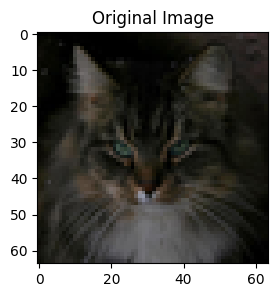

In [34]:
# Load the animal faces dataset
from datasets import load_dataset
from matplotlib import pyplot as plt
import numpy as np

dataset = load_dataset("zzsi/afhq64_16k", split="train")

# visualize the first example
img = dataset[0]["image"]
img = np.array(img).astype(np.float32) / 255.0
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.title("Original Image")
plt.show()


### Encoding the Image into the Latent Space

Take the first image in the dataset and encode it into the latent space.

In [18]:
import numpy as np

# Fix the random seed for reproducibility
torch.manual_seed(0)

img = dataset[0]["image"]
img = np.array(img).astype(np.float32) / 255.0
img = torch.from_numpy(img).unsqueeze(0).permute(0, 3, 1, 2)

print("Encoding the image into latent space...")
print("Shape of the image:", img.shape)
with torch.no_grad():
    latents = vae.encode(img).latent_dist.sample()

print("Shape of the latents:", latents.shape)
print("avg value of the latents:", latents.mean())

Encoding the image into latent space...
Shape of the image: torch.Size([1, 3, 64, 64])
Shape of the latents: torch.Size([1, 4, 8, 8])
avg value of the latents: tensor(0.6707)


The latents are 4 x 8 x 8, which means there are 4 channels of 2D "latent images", each of size 8 x 8. Since the original image is 64 x 64. The spatial compression ratio is 8.
The compressed latent images are much smaller! Our hope is that it makes training the diffusion model easier in the smaller latent space.

Now let's visualize the 4 channels of the latents.

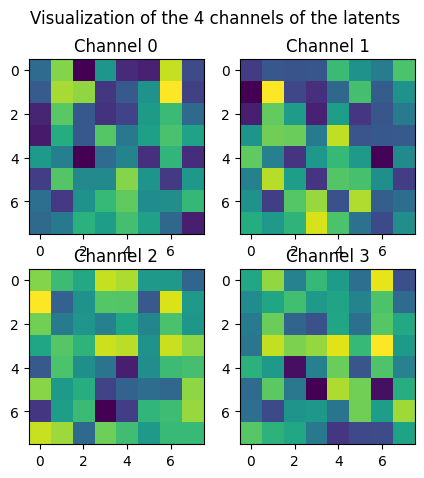

In [ ]:
# Visualize the latents
from matplotlib import pyplot as plt

# Use subplot to visualize the 4 channels of the latents
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
latents_np = latents.cpu().numpy()
axs[0, 0].imshow(latents_np[0, 0])
axs[0, 1].imshow(latents_np[0, 1])
axs[1, 0].imshow(latents_np[0, 2])
axs[1, 1].imshow(latents_np[0, 3])
# add a title to each subplot
axs[0, 0].set_title("Channel 0")
axs[0, 1].set_title("Channel 1")
axs[1, 0].set_title("Channel 2")
axs[1, 1].set_title("Channel 3")
# Add a title to the figure
fig.suptitle("Visualization of the 4 channels of the latents")
plt.show()

### Decoding the Latent Vectors back to the Image Space

Now let's decode the latents back to the image space, and see if we can reconstruct the original image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of the decoded image: (64, 64, 3)


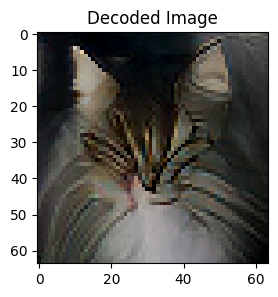

In [33]:
with torch.no_grad():
    decoder_output = vae.decode(latents)
    decoded_images = decoder_output.sample.cpu().numpy().transpose(0, 2, 3, 1)

print("Shape of the decoded image:", decoded_images.shape[1:])

# Visualize the decoded image
plt.figure(figsize=(3, 3))
plt.imshow(decoded_images[0])
plt.title("Decoded Image")
plt.show()


The reconstruction is not perfect, and we can see some artifacts.

Let's make the image larger.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


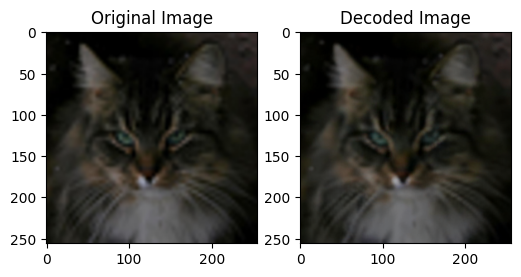

In [45]:

img = dataset[0]["image"].resize((256, 256))
img = np.array(img).astype(np.float32) / 255.0


img = torch.from_numpy(img).unsqueeze(0).permute(0, 3, 1, 2)
with torch.no_grad():
    latents = vae.encode(img).latent_dist.sample()
    decoded_images = vae.decode(latents).sample.cpu().numpy().transpose(0, 2, 3, 1)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(img.cpu().numpy().transpose(0, 2, 3, 1)[0])
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(decoded_images[0])
plt.title("Decoded Image")
plt.show()




Now with the 256 x 256 image, the reconstruction feels much better, even though the encoding and decoding steps are the same as before. If we look closely at small details, there are still artifacts. With this example, we now have intuitive understanding of the benefits and limitations of VAE models.

## Using VAE in the Diffusion Training and Generation

To use a VAE in the diffusion training, we just add an encoding step in the training loop:

```python
for images in dataloader:
    # Compress images into latent vectors
    latents = vae.encode(images)
    # Train the diffusion model on the latent vectors instead of the images
    ...
```

During generation, we can use the VAE to compress the generated latent vectors back to the image space:

```python
# Generate latent vectors
latents = # yourgeneration code ...

# Decode latent vectors back to images to visualize
images = vae.decode(latents)
```

However, this is not quite efficient, because the same training images are encoded again and again. Instead, we can pre-compute the latent vectors for all the training images and store them in a separate dataset.

In the next tutorial, we will apply this recipe to a larger dataset, MJ 600k images.
